# Assignment 4: Support Vector Machine (SVM)

In this assignment, we are given a dataset called 'data-breast-cancer.csv' to work on. We will use its attributes to build a breast cancer prediction model using different classification models, including but not limited to Suppor Vector Machine.
This is the overall approach:

- Load the data
- Remove outliers and clean the data
- Analyze the data
- Build, train and evaluate the SVM model
- Build, train and evaluate the other four classifiers (Logistic regression, Naive Bayes, Decision Tree, Random Forest), then compare their performance with the SVM model's

Let's get the ball rolling.

## Step 1: Data Loading
First and foremost, we must import necessary libraries for the training, which are Pandas, Numpy, Matplotlib, Seaborn, Pickle, and Scikit-learn.

In [ ]:
# Load neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load Scikit-learn's functions
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Load some useful functions
from imblearn.over_sampling import SMOTE

Then, we will upload the given dataset to this worksheet and read the loaded one using pandas. The dataset contains the tumors' characteristics and whether they are malignant or benignused. To confirm that the data loading is successful, we will print out the dataset as following.

In [ ]:
# Load the dataset
df = pd.read_csv("data-breast-cancer.csv")

# Show some data samples
df.head()

,Unnamed: 0,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Some useful attributes in the dataset are:

- diagnosis: (label) the diagnosis of breast (label) tissues (M = malignant, B = benign).
- radius: distances from center to points on the perimeter.
- texture: standard deviation of gray-scale values.
- perimeter: perimeter of the tumor.
- area: area of the tumor.
- smoothness: local variation in radius lengths.
- compactness: is equal to (perimeter^2 / area - 1.0).
- concavity: severity of concave portions of the contour.
- concave points: number of concave portions of the contour.
- symmetry: symmetry of the tumor shape.
- fractal dimension: "coastline approximation" - 1.



Although we knew that there is only one categorical data features in this dataset–the data label, we still want to make sure that our assumption is correct by printing out the list of categorical features.

In [ ]:
# Get the list of categorical features
cat_cols = [col for col in df.columns if df[col].dtypes=="O"]
cat_cols

['diagnosis']

Since the above list has only one item–"diagnosis", we are convinced that there is no categorical attributes in this dataset except the data label. Since this is a classification problem, no further categorical encoding is needed.

## Step 2: Data Processing

In this section, we will first remove the highly correlated attributes. Then we remove the outliers and separate the data labels from the dataset.

Before processing the data, we will make a copy of the data to preserve the orginial one in case we did something inappropriately. We also drop useless columns such as `Unnamed: 0`.

In [ ]:
# Make a data copy
data = df.copy()

# Drop irrelavent attributes
data = data.drop(columns = ["Unnamed: 0"], axis = 1)

### 2.1. Correlation Removal

We will remove any highly correlated attributes (covariance > `0.8` or < `-0.8`). We will use the correlation heatmap to visualize all pairs' correlation.

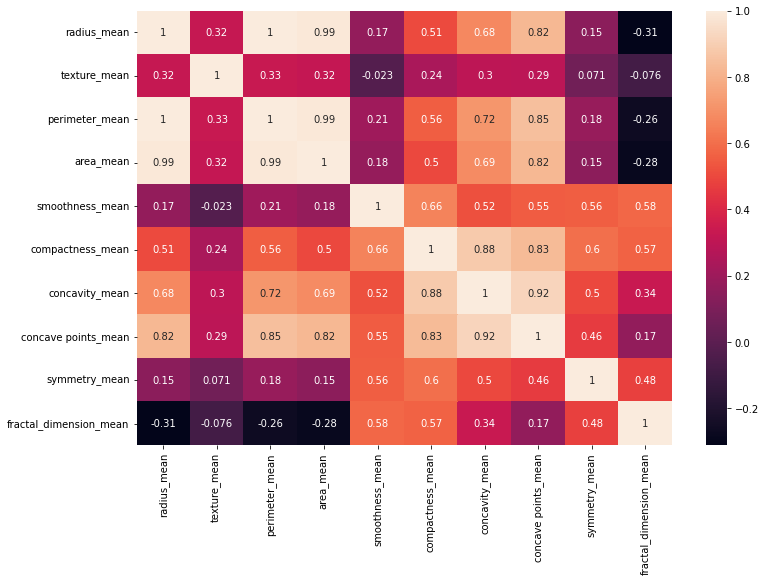

In [ ]:
# Plot the correlation heatmap between pairs of features
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(), annot = True)

From the above picture, there are 9 positively correlated pairs of attributes, which are:
- *radius_mean* and *perimeter_mean*
- *radius_mean* and *area_mean*
- *radius_mean* and *concave points_mean*
- *perimeter_mean* and *area_mean*
- *perimeter_mean* and *concave points_mean*
- *concave points_mean* and *area_mean* 
- *concave points_mean* and *concavity_mean* 
- *concave points_mean* and *compactness_mean*
- *concavity_mean* and *compactness_mean*

Since *radius_mean*, *perimeter_mean*, and *area* are highly correlated (99-100%), we will remove two of them, which is *perimeter_mean* and *area*.

Since *concave points_mean* correlates with 4 other attributes, we will remove *concave points_mean* to preserve the model's complexity.

Since *compactness_mean* equals to $\frac{perimeter^2}{area} - 1.0$, so it must highly correlates with *radius_mean*, *perimeter_mean*, and *area_mean*. Moreover, it also highly correlates with *concavity_mean*. Therefore, we will remove *compactness_mean*.

In [ ]:
# Drop highly correlated data features
data = data.drop(columns = ["concave points_mean", "compactness_mean",
                            "perimeter_mean", "area_mean"],  axis = 1)

After the attributes removal, we will plot the correlation heatmap again to verify that there is no highly correlated item.

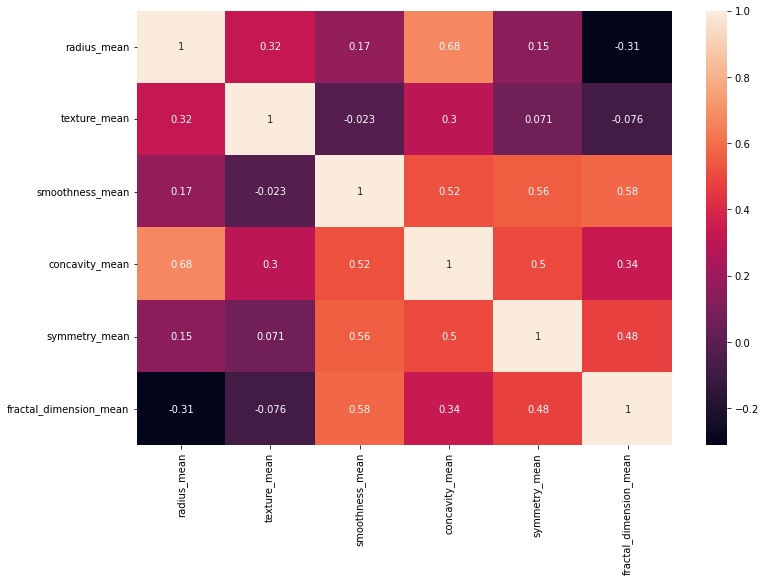

In [ ]:
# Plot the correlation heatmap between pairs of features
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(), annot = True)

It is clear that there is no highly correlation item anymore. And after the processing, our dataset now contains only 6 data features, which is quite small but we will try to work with it.

### 2.2. Outliers Removal

Then, we will remove outliers from the dataset. But first, let us visualize all the values of each attribute in boxplot. Since there are 6 attributes, we will have 6 corresponding boxplots.

Text(0.5, 1.0, 'fractal_dimension_mean')

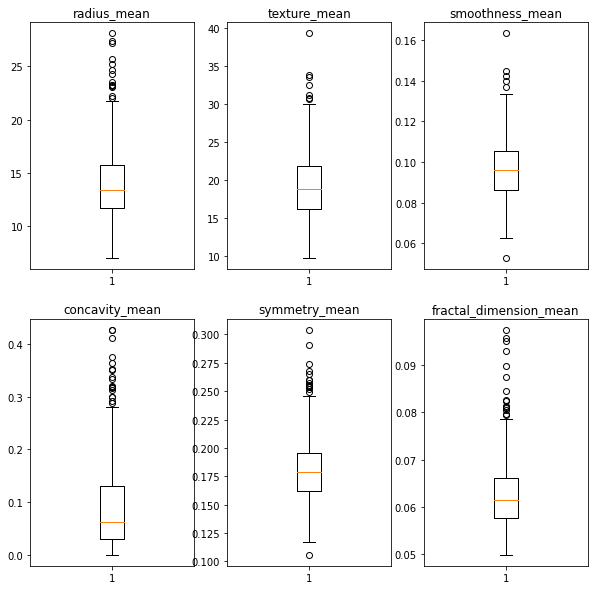

In [ ]:
# Draw boxplots
fig, axs = plt.subplots(2, 3, figsize = [10, 10])

# Radius_mean boxplot
axs[0, 0].boxplot(data["radius_mean"])
axs[0, 0].set_title('radius_mean')

# Texture_mean boxplot
axs[0, 1].boxplot(data["texture_mean"])
axs[0, 1].set_title('texture_mean')

# Smoothness_mean boxplot
axs[0, 2].boxplot(data["smoothness_mean"])
axs[0, 2].set_title('smoothness_mean')

# Compactness_mean boxplot
axs[1, 0].boxplot(data["concavity_mean"])
axs[1, 0].set_title('concavity_mean')

# Symmetry_mean boxplot
axs[1, 1].boxplot(data["symmetry_mean"])
axs[1, 1].set_title('symmetry_mean')

# Fractal_dimension_mean boxplot
axs[1, 2].boxplot(data["fractal_dimension_mean"])
axs[1, 2].set_title('fractal_dimension_mean')

From the above graphs, we can obtain that most outliers lie above the `Q3 + 1.5 * IQR` line. Therefore, we will remove all the data points that has an attribute's value locates above the `Q3 + 1.5 * IQR` line.

In [ ]:
# Calculate the value at Q3 + 1.5 * IQR
def upper_whisker(attr):
  q3 = attr.quantile(0.75)
  q1 = attr.quantile(0.25)
  return 2.5 * q3 - 1.5 * q1

# Clean data above the upper whisker
data_clean = data[data['radius_mean'] < upper_whisker(data['radius_mean'])]
data_clean = data[data['texture_mean'] < upper_whisker(data['texture_mean'])]
data_clean = data[data['smoothness_mean'] < upper_whisker(data['smoothness_mean'])]
data_clean = data[data['concavity_mean'] < upper_whisker(data['concavity_mean'])]
data_clean = data[data['symmetry_mean'] < upper_whisker(data['symmetry_mean'])]
data_clean = data[data['fractal_dimension_mean'] < upper_whisker(data['fractal_dimension_mean'])]
data_clean.shape

(554, 7)

After the cleaning, we will check whether there are any nAn values in the dataset.

In [ ]:
# Check nAn values in the data
data_clean[data_clean.isna().any(axis=1)]

,diagnosis,radius_mean,texture_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean


Since there is no nAn value, no additional action is needed. Therefore, we will work with a dataset of 554 data points and 6 attributes.

### 2.3. Data Separation

Then, we will move the data label column from the dataset into a variable to make sure that the labels are not leaked into the model training process. To confirm that the removal is successful, we will print the data out.

In [ ]:
# Assign data label to variable 'labels'
labels = data_clean["diagnosis"]

# Drop the data label
data_clean = data_clean.drop(columns = ["diagnosis"], axis = 1)
data_clean

,radius_mean,texture_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,0.11840,0.30010,0.2419,0.07871
1,20.57,17.77,0.08474,0.08690,0.1812,0.05667
2,19.69,21.25,0.10960,0.19740,0.2069,0.05999
4,20.29,14.34,0.10030,0.19800,0.1809,0.05883
5,12.45,15.70,0.12780,0.15780,0.2087,0.07613
...,...,...,...,...,...,...
564,21.56,22.39,0.11100,0.24390,0.1726,0.05623
565,20.13,28.25,0.09780,0.14400,0.1752,0.05533
566,16.60,28.08,0.08455,0.09251,0.1590,0.05648
567,20.60,29.33,0.11780,0.35140,0.2397,0.07016


## Step 3: Data Analysis

Next, we will split the processed dataset into 2 sets: training and testing. 80% of the data will be put in the training set and 20% will be put in the testing set. 

In [ ]:
# Split train/test with a 8:2 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_clean, labels,
                                                    random_state = 10,
                                                    train_size = 0.8)

After that, we prepare the normalized data using StandardScaler. The StandardScaler's job is to standardize the given data by removing the mean and scaling them to the unit variance.

In [ ]:
# Initialize and use StandardScaler to normalize the data
scaler = StandardScaler()
X_normalized_train = scaler.fit_transform(X_train)     # Fit and transform thr training data
X_normalized_test = scaler.transform(X_test)           # Only transform the test data.

Let's focus on the training set. For each unique label (`M` and `B`), we will print out the number of values to see whether or not this set is imbalanced.

In [ ]:
# Print number of labels' entries
print(np.unique(y_train, return_counts = True))   

(array(['B', 'M'], dtype=object), array([275, 168]))


It is clear that our training set is quite imbalanced. The ratio of `B` and `M` is `1.63`. Therefore, we will try to apply techniques for imbalanced dataset and observe the difference regarding model performance.

## Step 4: Support Vector Machine Prediction Model

Since our output labels are categorical ("0" and "1") and the dataset is imbalanced, we will apply 2 classification SVM models on our training set. While one model will use SMOTE to oversample the dataset, the other will work with the original dataset. Both models will be applied GridSearchCV to find their best set of hyperparameters.


### 4.1. With Original Data

First, we will find the best hyper-parameters for the SVM model. We set the hyper-parameter C is for soft margin SVM to be from 0.01 to 1000, which is a pretty large range. This is because we don't know the range for the value of C. Besides, we also set the range for gamma to be either between 0.001 and 0.1 or scaled.

In [ ]:
# Criteria for the hyper-parameters
param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000],     # Soft margin SVM
              "gamma": ["scale", 0.001, 0.005, 0.1]}  # Non linear hyperplanes

# Find the best hyper-parameters for our training dataset with 10-fold cross-vallidation
gridsearch = GridSearchCV(SVC(), param_grid, cv = 10, scoring = "f1", verbose = 1) 
gridsearch.fit(X_normalized_train, y_train.replace(["B", "M"], [0, 1]))

# Best set of hyper-parameters found after searching
best_c = gridsearch.best_params_['C']
best_gamma = gridsearch.best_params_['gamma']
gridsearch.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'C': 10, 'gamma': 0.1}

Since the above hyper-parameters make sense to us, we will use it to train the SVM model.

In [ ]:
# SVM with the best set of hyper-parameters.
model = SVC(C = best_c, gamma = best_gamma)
model.fit(X_normalized_train, y_train)

# Show evaluation metrics on the test set
print(classification_report(y_test, model.predict(X_normalized_test)))

              precision    recall  f1-score   support

           B       0.97      0.97      0.97        72
           M       0.95      0.95      0.95        39

    accuracy                           0.96       111
   macro avg       0.96      0.96      0.96       111
weighted avg       0.96      0.96      0.96       111



We can see that the performance is impressively high. The weighted average `f1-score` is `0.96` and there is no score lower than `0.95`. Moreover, the model also well handles both classes as there is little difference in score when predicting `B` or `M`.

### 4.2. With SMOTE

Since our dataset is imbalanced, we will try to apply SMOTE to over-sample the training set. The intuition behind this action is that we want to see whether we can obtain a better prediction using SMOTE.

In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state = 5)     

# Oversample label 'M' (minority class) in the training set
X_train_oversampling, y_train_oversampling = smote.fit_resample(X_normalized_train, y_train)     

To confirm that SMOTE is sucessfully done,  we will check whether number of entries in each label are the same.

In [ ]:
# Print number of labels' entries
print(np.unique(y_train_oversampling, return_counts = True))

(array(['B', 'M'], dtype=object), array([275, 275]))


As you can see, label `M` and `B` have the same number of entries. Next, we will find the best hyper-parameters for the SVM model. The criteria for the hyper-parameters will remain the same.

In [ ]:
# Find the best hyper-parameters for our training dataset with 10-fold cross-vallidation
gridsearch = GridSearchCV(SVC(), param_grid, cv = 10, scoring = "f1", verbose = 1) 
gridsearch.fit(X_train_oversampling,
               y_train_oversampling.replace(["B", "M"], [0, 1]))

# Best set of hyper-parameters found after searching
best_c = gridsearch.best_params_['C']
best_gamma = gridsearch.best_params_['gamma']
gridsearch.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'C': 1, 'gamma': 0.1}

Since the above hyper-parameters make sense to us, we will use it to train the SVM model.

In [ ]:
# SVM with the best set of hyper-parameters.
model = SVC(C = best_c, gamma = best_gamma)
model.fit(X_train_oversampling, y_train_oversampling)

# Show evaluation metrics on the test set
print(classification_report(y_test, model.predict(X_normalized_test)))

              precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.92      0.95        39

    accuracy                           0.96       111
   macro avg       0.97      0.95      0.96       111
weighted avg       0.96      0.96      0.96       111



Although there are impressive values in the performance score, the overall result does not differ much from that of the SVM model without SMOTE. Since the pros (i.e. higher scores in some places) does not out-weigh the cons (i.e. change the dataset's characteristics), we decide **NOT to apply SMOTE** when training other models. 

## Step 5: Other Prediction Models

In this section, we will train other 4 classification models to compare their performance with the SVM model. Our hypothesis is that these models will have lower performances comparing to SVM.

An important thing to remind is that we are going to work on the original dataset instead of the oversampling one. 

### 5.1. Logistic Regression

For the Logistic Regression model, we will use the default settings of the model pipeline instead of finding the best set of hyperparameter.

Therefore, we will train it right away and print out the performance score table.


In [ ]:
# Build a Logistic Regression model pipeline
log_model = LogisticRegression()   

# Train the Logistic Regression model
log_model.fit(X_normalized_train, y_train)   

# Show evaluation metrics on the test set
print(classification_report(y_test, log_model.predict(X_normalized_test)))

              precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.92      0.95        39

    accuracy                           0.96       111
   macro avg       0.97      0.95      0.96       111
weighted avg       0.96      0.96      0.96       111



As you can see, the performance of Logistic Regression is the same as SVM. While this is surprising to me, I believe that it is because our dataset was made easy for training models.

### 5.2. Naive Bayes

For the Naive Bayes model, we will also use the default settings of the model pipeline. Therefore, we will train it right away and print out the performance score table.

In [ ]:
# Build a Naive Bayes model pipeline
nb_model = GaussianNB()

# Train the Naive Bayes model
nb_model.fit(X_normalized_train, y_train)   

# Show evaluation metrics on the test set
print(classification_report(y_test, nb_model.predict(X_normalized_test)))

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.93        39

    accuracy                           0.95       111
   macro avg       0.96      0.94      0.95       111
weighted avg       0.96      0.95      0.95       111



As you can see, the performance of Naive Bayes is the slight lower than SVM. However, the difference is minor. While this is surprising to me, I believe that it is because our dataset was made easy for training models.

### 5.3. Decision Tree

First, we will find the best hyper-parameters for the Decision Tree model. We set the tree's maximum depth to be from 2 to 5 since there is 6 original attributes. Besides, we also set the minimum numner of samples for stop splitting to be from 3 to 9 to avoid overfitting.

In [ ]:
# Criteria for the hyper-parameters
params = {"criterion": ["gini", "entropy"],        # Criterion to evaluate the purity.
         "max_depth": range(2, 6),                 # Maximum depth of the tree
         "min_samples_split": range(3, 10)}        # Stop splitting condition.

# Find the best hyper-parameters for our training dataset with 5-fold cross-validation
dt_grid_search = GridSearchCV(estimator = DecisionTreeClassifier(),
                           param_grid = params, cv = 5)
dt_grid_search.fit(X_normalized_train, y_train)

# Best set of hyper-parameters found after searching
dt_best_criterion = dt_grid_search.best_params_['criterion']
dt_best_max_depth = dt_grid_search.best_params_['max_depth']
dt_best_min_samples_split = dt_grid_search.best_params_['min_samples_split']
dt_grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}

Since the above hyper-parameters make sense to us, we will use it to train the Decision Tree model. Then, we will evaluate the trained Decision Tree model above by applying it on the original test set.

In [ ]:
# Build a Decision Tree model pipeline from the best set of hyper-parameters found
dt_model = DecisionTreeClassifier(criterion = dt_best_criterion,
                                  max_depth = dt_best_max_depth,
                                  min_samples_split = dt_best_min_samples_split)

# Train the Decision Tree model
dt_model.fit(X_normalized_train, y_train)

# Show evaluation metrics on the test set
print(classification_report(y_test, dt_model.predict(X_normalized_test)))

              precision    recall  f1-score   support

           B       0.95      0.97      0.96        72
           M       0.95      0.90      0.92        39

    accuracy                           0.95       111
   macro avg       0.95      0.93      0.94       111
weighted avg       0.95      0.95      0.95       111



As you can see, the performance of Decision Tree is the slight lower than SVM. However, the difference is minor. While this is surprising to me, I believe that it is because our dataset was made easy for training models.

### 5.4. Random Forest 

To begin, we will find the best hyper-parameters for the Random Forest model. The criteria for the hyper-parameters will remain the same except there is an additional parameter called `n_estimators` representing the number of trees in the forest. For this parameter, we will set it to 10 cause 10 seems reasonable to us.

In [ ]:
# Find the best hyper-parameters for our training dataset with 5-fold cross-validation
rf_grid_search = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 10,
                                                                 n_jobs = 10),
                              param_grid = params, cv = 5) 
rf_grid_search.fit(X_train, y_train)

# Best set of hyper parameters of the Random Forest
rf_best_criterion = rf_grid_search.best_params_['criterion']
rf_best_max_depth = rf_grid_search.best_params_['max_depth']
rf_best_min_samples_split = rf_grid_search.best_params_['min_samples_split']
rf_grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 7}

Since the above hyper-parameters make sense to us, we will use it to train the Random Forest model. Then, we will evaluate the trained Random Forest model above by applying it on the original test set.

In [ ]:
# Build a Random Forest model pipeline from the best set of hyper-parameters found
rf_model = RandomForestClassifier(n_estimators = 10, random_state = 1,
                                  criterion = rf_best_criterion,
                                  max_depth = rf_best_max_depth,
                                  min_samples_split = rf_best_min_samples_split)  

# Train the Random Forest model
rf_model.fit(X_normalized_train, y_train)

# Show evaluation metrics on the test set
print(classification_report(y_test, rf_model.predict(X_normalized_test)))

              precision    recall  f1-score   support

           B       0.93      0.99      0.96        72
           M       0.97      0.87      0.92        39

    accuracy                           0.95       111
   macro avg       0.95      0.93      0.94       111
weighted avg       0.95      0.95      0.95       111



As you can see, the performance of Random Forest is the slight lower than SVM. However, the difference is minor. While this is surprising to me, I believe that it is because our dataset was made easy for training models.